In [1]:
import sys
sys.path.append('..')

In [2]:
from data_aquisition import twitter_data
from feature_engineering import features
import datetime as dt
import pandas as pd
import seaborn as sns
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import emojis
from nltk.tokenize import word_tokenize, sent_tokenize, TweetTokenizer, RegexpTokenizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

In [3]:
pd.options.display.max_rows = 10000
pd.set_option('display.max_colwidth', 150)
pd.options.display.max_columns = 10000

In [4]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}
matplotlib.rc('font', **font)

In [5]:
labeled_data = features.import_labeled_data()

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3249: DtypeWarning: Columns (0,1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [6]:
print(labeled_data.shape)
labeled_data.head()

(11190, 309)


,Datetime,Inflection_Point,Known_Pumper,Price_Region,Sentiment,Unnamed: 10,Unnamed: 100,Unnamed: 101,Unnamed: 102,Unnamed: 103,Unnamed: 104,Unnamed: 105,Unnamed: 106,Unnamed: 107,Unnamed: 108,Unnamed: 109,Unnamed: 11,Unnamed: 110,Unnamed: 111,Unnamed: 112,Unnamed: 113,Unnamed: 114,Unnamed: 115,Unnamed: 116,Unnamed: 117,Unnamed: 118,Unnamed: 119,Unnamed: 12,Unnamed: 120,Unnamed: 121,Unnamed: 122,Unnamed: 123,Unnamed: 124,Unnamed: 125,Unnamed: 126,Unnamed: 127,Unnamed: 128,Unnamed: 129,Unnamed: 13,Unnamed: 130,Unnamed: 131,Unnamed: 132,Unnamed: 133,Unnamed: 134,Unnamed: 135,Unnamed: 136,Unnamed: 137,Unnamed: 138,Unnamed: 139,Unnamed: 14,Unnamed: 140,Unnamed: 141,Unnamed: 142,Unnamed: 143,Unnamed: 144,Unnamed: 145,Unnamed: 146,Unnamed: 147,Unnamed: 148,Unnamed: 149,Unnamed: 15,Unnamed: 150,Unnamed: 151,Unnamed: 152,Unnamed: 153,Unnamed: 154,Unnamed: 155,Unnamed: 156,Unnamed: 157,Unnamed: 158,Unnamed: 159,Unnamed: 16,Unnamed: 160,Unnamed: 161,Unnamed: 162,Unnamed: 163,Unnamed: 164,Unnamed: 165,Unnamed: 166,Unnamed: 167,Unnamed: 168,Unnamed: 169,Unnamed: 17,Unnamed: 170,Unnamed: 171,Unnamed: 172,Unnamed: 173,Unnamed: 174,Unnamed: 175,Unnamed: 176,Unnamed: 177,Unnamed: 178,Unnamed: 179,Unnamed: 18,Unnamed: 180,Unnamed: 181,Unnamed: 182,Unnamed: 183,Unnamed: 184,Unnamed: 185,Unnamed: 186,Unnamed: 187,Unnamed: 188,Unnamed: 189,Unnamed: 19,Unnamed: 190,Unnamed: 191,Unnamed: 192,Unnamed: 193,Unnamed: 194,Unnamed: 195,Unnamed: 196,Unnamed: 197,Unnamed: 198,Unnamed: 199,Unnamed: 20,Unnamed: 200,Unnamed: 201,Unnamed: 202,Unnamed: 203,Unnamed: 204,Unnamed: 205,Unnamed: 206,Unnamed: 207,Unnamed: 208,Unnamed: 209,Unnamed: 21,Unnamed: 210,Unnamed: 211,Unnamed: 212,Unnamed: 213,Unnamed: 214,Unnamed: 215,Unnamed: 216,Unnamed: 217,Unnamed: 218,Unnamed: 219,Unnamed: 22,Unnamed: 220,Unnamed: 221,Unnamed: 222,Unnamed: 223,Unnamed: 224,Unnamed: 225,Unnamed: 226,Unnamed: 227,Unnamed: 228,Unnamed: 229,Unnamed: 23,Unnamed: 230,Unnamed: 231,Unnamed: 232,Unnamed: 233,Unnamed: 234,Unnamed: 235,Unnamed: 236,Unnamed: 237,Unnamed: 238,Unnamed: 239,Unnamed: 24,Unnamed: 240,Unnamed: 241,Unnamed: 242,Unnamed: 243,Unnamed: 244,Unnamed: 245,Unnamed: 246,Unnamed: 247,Unnamed: 248,Unnamed: 249,Unnamed: 25,Unnamed: 250,Unnamed: 251,Unnamed: 252,Unnamed: 253,Unnamed: 254,Unnamed: 255,Unnamed: 256,Unnamed: 257,Unnamed: 258,Unnamed: 259,Unnamed: 26,Unnamed: 260,Unnamed: 261,Unnamed: 262,Unnamed: 263,Unnamed: 264,Unnamed: 265,Unnamed: 266,Unnamed: 267,Unnamed: 268,Unnamed: 269,Unnamed: 27,Unnamed: 270,Unnamed: 271,Unnamed: 272,Unnamed: 273,Unnamed: 274,Unnamed: 275,Unnamed: 276,Unnamed: 277,Unnamed: 278,Unnamed: 279,Unnamed: 28,Unnamed: 280,Unnamed: 281,Unnamed: 282,Unnamed: 283,Unnamed: 284,Unnamed: 285,Unnamed: 286,Unnamed: 287,Unnamed: 288,Unnamed: 289,Unnamed: 29,Unnamed: 290,Unnamed: 291,Unnamed: 292,Unnamed: 293,Unnamed: 294,Unnamed: 295,Unnamed: 296,Unnamed: 297,Unnamed: 298,Unnamed: 299,Unnamed: 30,Unnamed: 300,Unnamed: 301,Unnamed: 302,Unnamed: 303,Unnamed: 304,Unnamed: 305,Unnamed: 306,Unnamed: 307,Unnamed: 308,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40,Unnamed: 41,Unnamed: 42,Unnamed: 43,Unnamed: 44,Unnamed: 45,Unnamed: 46,Unnamed: 47,Unnamed: 48,Unnamed: 49,Unnamed: 50,Unnamed: 51,Unnamed: 52,Unnamed: 53,Unnamed: 54,Unnamed: 55,Unnamed: 56,Unnamed: 57,Unnamed: 58,Unnamed: 59,Unnamed: 60,Unnamed: 61,Unnamed: 62,Unnamed: 63,Unnamed: 64,Unnamed: 65,Unnamed: 66,Unnamed: 67,Unnamed: 68,Unnamed: 69,Unnamed: 70,Unnamed: 71,Unnamed: 72,Unnamed: 73,Unnamed: 74,Unnamed: 75,Unnamed: 76,Unnamed: 77,Unnamed: 78,Unnamed: 79,Unnamed: 8,Unnamed: 80,Unnamed: 81,Unnamed: 82,Unnamed: 83,Unnamed: 84,Unnamed: 85,Unnamed: 86,Unnamed: 87,Unnamed: 88,Unnamed: 89,Unnamed: 9,Unnamed: 90,Unnamed: 91,Unnamed: 92,Unnamed: 93,Unnamed: 94,Unnamed: 95,Unnamed: 96,Unnamed: 97,Unnamed: 98,Unnamed: 99,id_str,text,user.screen_name
0,2021-03-25 17:50:13+00:00,NaN,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [7]:
labeled_data.isna().any()

Datetime             True
Inflection_Point     True
Known_Pumper        False
Price_Region         True
Sentiment           False
Unnamed: 10          True
Unnamed: 100         True
Unnamed: 101         True
Unnamed: 102         True
Unnamed: 103         True
Unnamed: 104         True
Unnamed: 105         True
Unnamed: 106         True
Unnamed: 107         True
Unnamed: 108         True
Unnamed: 109         True
Unnamed: 11          True
Unnamed: 110         True
Unnamed: 111         True
Unnamed: 112         True
Unnamed: 113         True
Unnamed: 114         True
Unnamed: 115         True
Unnamed: 116         True
Unnamed: 117         True
Unnamed: 118         True
Unnamed: 119         True
Unnamed: 12          True
Unnamed: 120         True
Unnamed: 121         True
Unnamed: 122         True
Unnamed: 123         True
Unnamed: 124         True
Unnamed: 125         True
Unnamed: 126         True
Unnamed: 127         True
Unnamed: 128         True
Unnamed: 129         True
Unnamed: 13 

In [8]:
tweet_data = twitter_data.read_all_twitter_data(folder='../data_aquisition/twitter_raw_data/clean_data/')

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pas

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pas

In [9]:
# Merging sentiment data to original dataset 
labeled_tweets = labeled_data[['id_str', 'Sentiment', 'Known_Pumper', 'Price_Region', 'Inflection_Point']].merge(tweet_data, on='id_str')

In [10]:
labeled_tweets.head()

,id_str,Sentiment,Known_Pumper,Price_Region,Inflection_Point,contributors,coordinates,created_at,entities.hashtags,entities.media,entities.symbols,entities.urls,entities.user_mentions,extended_entities.media,favorite_count,favorited,geo,id,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,is_quote_status,lang,metadata.iso_language_code,metadata.result_type,place,place.bounding_box.coordinates,place.bounding_box.type,place.contained_within,place.country,place.country_code,place.full_name,place.id,place.name,place.place_type,place.url,possibly_sensitive,quoted_status.contributors,quoted_status.coordinates,quoted_status.created_at,quoted_status.entities.hashtags,quoted_status.entities.media,quoted_status.entities.symbols,quoted_status.entities.urls,quoted_status.entities.user_mentions,quoted_status.extended_entities.media,quoted_status.favorite_count,quoted_status.favorited,quoted_status.geo,quoted_status.id,quoted_status.id_str,quoted_status.in_reply_to_screen_name,quoted_status.in_reply_to_status_id,quoted_status.in_reply_to_status_id_str,quoted_status.in_reply_to_user_id,quoted_status.in_reply_to_user_id_str,quoted_status.is_quote_status,quoted_status.lang,quoted_status.metadata.iso_language_code,quoted_status.metadata.result_type,quoted_status.place,quoted_status.place.bounding_box.coordinates,quoted_status.place.bounding_box.type,quoted_status.place.contained_within,quoted_status.place.country,quoted_status.place.country_code,quoted_status.place.full_name,quoted_status.place.id,quoted_status.place.name,quoted_status.place.place_type,quoted_status.place.url,quoted_status.possibly_sensitive,quoted_status.quoted_status_id,quoted_status.quoted_status_id_str,quoted_status.retweet_count,quoted_status.retweeted,quoted_status.source,quoted_status.text,quoted_status.truncated,quoted_status.user.contributors_enabled,quoted_status.user.created_at,quoted_status.user.default_profile,quoted_status.user.default_profile_image,quoted_status.user.description,quoted_status.user.entities.description.urls,quoted_status.user.entities.url.urls,quoted_status.user.favourites_count,quoted_status.user.follow_request_sent,quoted_status.user.followers_count,quoted_status.user.following,quoted_status.user.friends_count,quoted_status.user.geo_enabled,quoted_status.user.has_extended_profile,quoted_status.user.id,quoted_status.user.id_str,quoted_status.user.is_translation_enabled,quoted_status.user.is_translator,quoted_status.user.lang,quoted_status.user.listed_count,quoted_status.user.location,quoted_status.user.name,quoted_status.user.notifications,quoted_status.user.profile_background_color,quoted_status.user.profile_background_image_url,quoted_status.user.profile_background_image_url_https,quoted_status.user.profile_background_tile,quoted_status.user.profile_banner_url,quoted_status.user.profile_image_url,quoted_status.user.profile_image_url_https,quoted_status.user.profile_link_color,quoted_status.user.profile_sidebar_border_color,quoted_status.user.profile_sidebar_fill_color,quoted_status.user.profile_text_color,quoted_status.user.profile_use_background_image,quoted_status.user.protected,quoted_status.user.screen_name,quoted_status.user.statuses_count,quoted_status.user.time_zone,quoted_status.user.translator_type,quoted_status.user.url,quoted_status.user.utc_offset,quoted_status.user.verified,quoted_status_id,quoted_status_id_str,retweet_count,retweeted,retweeted_status.contributors,retweeted_status.coordinates,retweeted_status.created_at,retweeted_status.entities.hashtags,retweeted_status.entities.media,retweeted_status.entities.symbols,retweeted_status.entities.urls,retweeted_status.entities.user_mentions,retweeted_status.extended_entities.media,retweeted_status.favorite_count,retweeted_status.favorited,retweeted_status.geo,retweeted_status.id,retweeted_status.id_str,retweeted_status.in_reply_to_screen_name,retweeted_status.in_reply_to_status_id,retweeted_status.in_reply_to_status_id

In [11]:
# Filter down to columns we want to focus on for sentiment model 
labeled_tweets[['id_str','text', 'entities.hashtags', 'Sentiment']].head(50)

,id_str,text,entities.hashtags,Sentiment
0,1375142994920271872,#RT @ldev117: RT @UCitnow: @ShortSqueezed1 @EVO9MRPLEASE $AXTG New intern CEO https://t.co/oCOI6nRC6G,"[{'text': 'RT', 'indices': [0, 3]}]",0.0
1,1375143141058080768,RT @UCitnow: #RT @ldev117: RT @UCitnow: @ShortSqueezed1 @EVO9MRPLEASE $AXTG New intern CEO https://t.co/oCOI6nRC6G,"[{'text': 'RT', 'indices': [13, 16]}]",0.0
2,1375157484063584261,$AXTG Big OTC % Gainer!🚀🚀🚀,[],1.0
3,1375176172099747845,Today’s Top Penny Stock Gainers\n\n$LTTGF $AXTG $SEVA $AFOM $DVLP $RGBPP $GNPK-WS $IMMP $ETFM\n\n#pennystocks… https://t.co/nBJ2yCqTZF,"[{'text': 'pennystocks', 'indices': [93, 105]}]",1.0
4,1375176361560604679,RT @GetScanz: Today’s Top Penny Stock Gainers\n\n$LTTGF $AXTG $SEVA $AFOM $DVLP $RGBPP $GNPK-WS $IMMP $ETFM\n\n#pennystocks #hotstocks #otcbb #…,"[{'text': 'pennystocks', 'indices': [107, 119]}, {'text': 'hotstocks', 'indices': [120, 130]}, {'text': 'otcbb', 'indices': [131, 137]}]",1.0
5,1375182761229684742,RT @GetScanz: Today’s Top Penny Stock Gainers\n\n$LTTGF $AXTG $SEVA $AFOM $DVLP $RGBPP $GNPK-WS $IMMP $ETFM\n\n#pennystocks #hotstocks #otcbb #…,"[{'text': 'pennystocks', 'indices': [107, 119]}, {'text': 'hotstocks', 'indices': [120, 130]}, {'text': 'otcbb', 'indices': [131, 137]}]",1.0
6,1375455671689170953,That is a great point! NFT is huge and $HMBL has all the tools in place to become a player. Shareholders have so ma… https://t.co/tIDWrRkVNa,[],1.0
7,1375455908470386697,RT @jehause: That is a great point! NFT is huge and $HMBL has all the tools in place to become a player. Shareholders have so many catalyst…,[],1.0
8,1375456626392596484,RT @jehause: That is a great point! NFT is huge and $HMBL has all the tools in place to become a player. Shareholders have so many catalyst…,[],1.0
9,1375456640745369601,RT @jehause: That is a great point! NFT is huge and $HMBL has all the tools in place to become a player. Shareholders have so many catalyst…,[],1.0


In [12]:
train_data = labeled_tweets[['text', 'entities.hashtags', 'Sentiment', 'Price_Region', 'Inflection_Point', 'Known_Pumper']]

In [13]:
# Removing -2 values on sentiment
train_data = train_data[train_data['Sentiment'] > -2.0]
train_data = train_data.dropna(subset=['Sentiment', 'text'])
train_data.shape

(11189, 6)

In [14]:
# Change all text to lowercase
train_data['text'] = train_data['text'].str.lower()

In [15]:
# Remove all periods and commas, delete preceding spaces
train_data['text'] = train_data['text'].str.replace(',', '')
train_data['text'] = train_data['text'].str.replace('.', '')
train_data['text'] = train_data['text'].str.strip()
# Remove the '...'
train_data['text'] = train_data['text'].str.replace(r'…', '', regex=True)

In [16]:
# Remove hyperlinks
train_data['text'] = train_data['text'].replace(r'http\S+', '', regex=True)

In [17]:
# Remove chinese characters
# train_data['text'] = train_data['text'].replace(r'[\p{script=Han}]', '', regex=True)

In [18]:
train_data.head()

,text,entities.hashtags,Sentiment,Price_Region,Inflection_Point,Known_Pumper
0,#rt @ldev117: rt @ucitnow: @shortsqueezed1 @evo9mrplease $axtg new intern ceo,"[{'text': 'RT', 'indices': [0, 3]}]",0.0,1.0,NaN,0.0
1,rt @ucitnow: #rt @ldev117: rt @ucitnow: @shortsqueezed1 @evo9mrplease $axtg new intern ceo,"[{'text': 'RT', 'indices': [13, 16]}]",0.0,1.0,NaN,0.0
2,$axtg big otc % gainer!🚀🚀🚀,[],1.0,1.0,NaN,0.0
3,today’s top penny stock gainers\n\n$lttgf $axtg $seva $afom $dvlp $rgbpp $gnpk-ws $immp $etfm\n\n#pennystocks,"[{'text': 'pennystocks', 'indices': [93, 105]}]",1.0,1.0,NaN,0.0
4,rt @getscanz: today’s top penny stock gainers\n\n$lttgf $axtg $seva $afom $dvlp $rgbpp $gnpk-ws $immp $etfm\n\n#pennystocks #hotstocks #otcbb #,"[{'text': 'pennystocks', 'indices': [107, 119]}, {'text': 'hotstocks', 'indices': [120, 130]}, {'text': 'otcbb', 'indices': [131, 137]}]",1.0,1.0,NaN,0.0


In [19]:
train_data.iloc[3]['text']

'today’s top penny stock gainers\n\n$lttgf $axtg $seva $afom $dvlp $rgbpp $gnpk-ws $immp $etfm\n\n#pennystocks '

In [20]:
# Replace \n with as space 
train_data['text'] = train_data['text'].replace(r'\n', ' ', regex=True)

In [21]:
train_data.head()

,text,entities.hashtags,Sentiment,Price_Region,Inflection_Point,Known_Pumper
0,#rt @ldev117: rt @ucitnow: @shortsqueezed1 @evo9mrplease $axtg new intern ceo,"[{'text': 'RT', 'indices': [0, 3]}]",0.0,1.0,NaN,0.0
1,rt @ucitnow: #rt @ldev117: rt @ucitnow: @shortsqueezed1 @evo9mrplease $axtg new intern ceo,"[{'text': 'RT', 'indices': [13, 16]}]",0.0,1.0,NaN,0.0
2,$axtg big otc % gainer!🚀🚀🚀,[],1.0,1.0,NaN,0.0
3,today’s top penny stock gainers $lttgf $axtg $seva $afom $dvlp $rgbpp $gnpk-ws $immp $etfm #pennystocks,"[{'text': 'pennystocks', 'indices': [93, 105]}]",1.0,1.0,NaN,0.0
4,rt @getscanz: today’s top penny stock gainers $lttgf $axtg $seva $afom $dvlp $rgbpp $gnpk-ws $immp $etfm #pennystocks #hotstocks #otcbb #,"[{'text': 'pennystocks', 'indices': [107, 119]}, {'text': 'hotstocks', 'indices': [120, 130]}, {'text': 'otcbb', 'indices': [131, 137]}]",1.0,1.0,NaN,0.0


In [22]:
train_data.iloc[3]['text']

'today’s top penny stock gainers  $lttgf $axtg $seva $afom $dvlp $rgbpp $gnpk-ws $immp $etfm  #pennystocks '

In [23]:
# Remove stock tags
train_data['text'] = train_data['text'].replace(r'\$\S+', '', regex=True)

In [24]:
train_data.head()

,text,entities.hashtags,Sentiment,Price_Region,Inflection_Point,Known_Pumper
0,#rt @ldev117: rt @ucitnow: @shortsqueezed1 @evo9mrplease new intern ceo,"[{'text': 'RT', 'indices': [0, 3]}]",0.0,1.0,NaN,0.0
1,rt @ucitnow: #rt @ldev117: rt @ucitnow: @shortsqueezed1 @evo9mrplease new intern ceo,"[{'text': 'RT', 'indices': [13, 16]}]",0.0,1.0,NaN,0.0
2,big otc % gainer!🚀🚀🚀,[],1.0,1.0,NaN,0.0
3,today’s top penny stock gainers #pennystocks,"[{'text': 'pennystocks', 'indices': [93, 105]}]",1.0,1.0,NaN,0.0
4,rt @getscanz: today’s top penny stock gainers #pennystocks #hotstocks #otcbb #,"[{'text': 'pennystocks', 'indices': [107, 119]}, {'text': 'hotstocks', 'indices': [120, 130]}, {'text': 'otcbb', 'indices': [131, 137]}]",1.0,1.0,NaN,0.0


In [25]:
train_data.iloc[3]['text']

'today’s top penny stock gainers            #pennystocks '

In [26]:
train_data.iloc[4]['text']

'rt @getscanz: today’s top penny stock gainers            #pennystocks #hotstocks #otcbb #'

In [27]:
# Create feature for number of exclamation marks
train_data['exc_count'] = train_data['text'].map(lambda x: x.count("!"))

In [28]:
# Create a column for number of characters 
train_data['characters_nb'] = train_data.text.apply(len)

In [29]:
# Remove tags
train_data['text'] = train_data['text'].replace(r'\@\S+', '', regex=True)

In [30]:
# Add count for emojis
train_data['emoji_count'] = train_data['text'].map(lambda x: emojis.count(x))

In [31]:
# Create decoded version of text field
train_data['text_dec'] = train_data['text'].map(lambda x: emojis.decode(x))

In [32]:
# Add spaces around emojis so they can be separated as words 
train_data['text_dec'] = train_data['text_dec'].replace(r'(:[a-z]+:)', ' \\1 ', regex=True)

In [33]:
train_data.head()

,text,entities.hashtags,Sentiment,Price_Region,Inflection_Point,Known_Pumper,exc_count,characters_nb,emoji_count,text_dec
0,#rt rt new intern ceo,"[{'text': 'RT', 'indices': [0, 3]}]",0.0,1.0,NaN,0.0,0,73,0,#rt rt new intern ceo
1,rt #rt rt new intern ceo,"[{'text': 'RT', 'indices': [13, 16]}]",0.0,1.0,NaN,0.0,0,86,0,rt #rt rt new intern ceo
2,big otc % gainer!🚀🚀🚀,[],1.0,1.0,NaN,0.0,1,21,3,big otc % gainer! :rocket: :rocket: :rocket:
3,today’s top penny stock gainers #pennystocks,"[{'text': 'pennystocks', 'indices': [93, 105]}]",1.0,1.0,NaN,0.0,0,56,0,today’s top penny stock gainers #pennystocks
4,rt today’s top penny stock gainers #pennystocks #hotstocks #otcbb #,"[{'text': 'pennystocks', 'indices': [107, 119]}, {'text': 'hotstocks', 'indices': [120, 130]}, {'text': 'otcbb', 'indices': [131, 137]}]",1.0,1.0,NaN,0.0,0,89,0,rt today’s top penny stock gainers #pennystocks #hotstocks #otcbb #


In [34]:
train_data.iloc[3]['text_dec']

'today’s top penny stock gainers            #pennystocks '

In [35]:
train_data.isna().any()

text                 False
entities.hashtags    False
Sentiment            False
Price_Region          True
Inflection_Point      True
Known_Pumper         False
exc_count            False
characters_nb        False
emoji_count          False
text_dec             False
dtype: bool

# Text mining

In [36]:
# Adding plots from midterm
def top_words(df, field, label_col, top_words_num):
    topWords = []
    df = df[df[label_col].notna()]
    tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+|:[a-z]+:')
    labels = df[label_col].unique()
    print("Labels for {}:".format(label_col))
    print(labels)
    for label in labels:
        # print("Top {} words for Score = {}".format(top_words_num, i))
        # print(df[df['Score'] == float(i)][field].head())
        # print(df[df['Score'] == float(i)][field].tolist()[878:880])
        words = pd.Series(tokenizer.tokenize(' '.join(df[df['Sentiment'] == float(label)][field].dropna().tolist())))
        topWordsForScore = words.where(~words.index.isin(stopwords.words()))
        # print(topWordsForScore.head())
        # print(topWordsForScore.shape)
        
#         print(topWordsForScore.value_counts()[:top_words_num].index.tolist())
#         print()
        topWords.append(topWordsForScore)
    
    for i, label in zip(range(len(topWords)), labels):
    
        fig, ax = plt.subplots(figsize=(30,15))
        allExcepti = topWords[:i] + topWords[i+1:]
        flattened = pd.concat(allExcepti)
        topWords[i] = topWords[i].where(~topWords[i].index.isin(flattened.value_counts()[:top_words_num].index.tolist()))
        print("Top {} words sort of unique to {} = {}".format(top_words_num, label_col, label))
        print(topWords[i].value_counts()[:top_words_num].index.tolist())
        print()
        topWords[i].value_counts()[:top_words_num].plot(kind='bar', ax=ax)
        plt.title("Top {} word counts unique to {} = {}".format(top_words_num, label_col, label))
        plt.savefig('{}_{}.png'.format(label_col, label))
        plt.show()
        

Labels for Sentiment:
[ 0.  1. -1.]


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


Top 50 words sort of unique to Sentiment = 0.0
['rt', 'the', 'and', 'to', ':', 'of', 'for', '%', 'on', 'a', 'i', 'in', 'at', ':fire:', '-', 'is', 'news', 'you', 'with', '2021', 'this', ':star:', '&amp;', 'will', 'it', 'new', 'be', 'from', '20', 'today', '%)', 'company', 'have', ':moneybag:', 'march', 'days', 'what', '️', '!', 'million', '’s', 'made', '?', 'or', 'we', 'was', 'my', '’t', '#stocks', 'just']



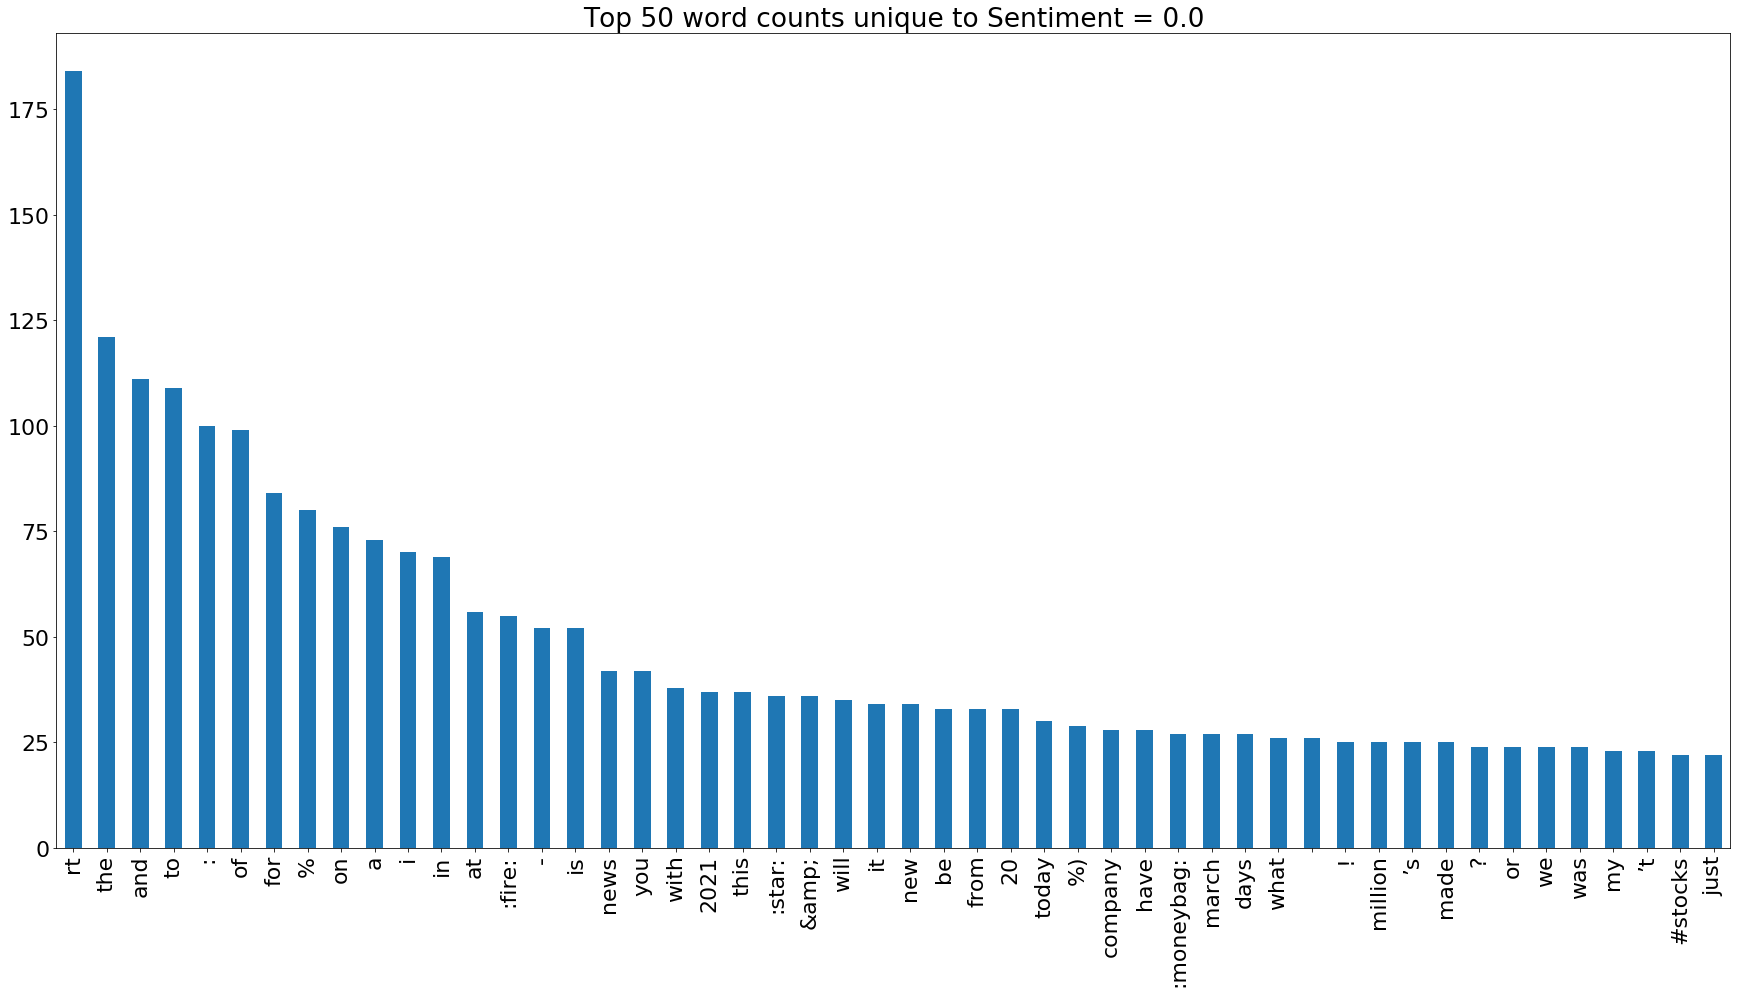

Top 50 words sort of unique to Sentiment = 1.0
[':rocket:', ':fire:', 'rt', 'the', 'to', '!', 'this', 'is', ':moneybag:', ':gem:', 'in', '🛢', 'on', 'i', 'and', ':collision:', 'a', 'for', 'of', 'it', 'you', '’s', ':thinking:', 'be', 'my', 'up', 'we', '3', ':dollar:', 'oil', ':eyes:', 'will', 'going', ':dash:', 'today', 'out', 'news', '-', 'get', 'like', 'if', 'week', '?', 'at', 'have', 'now', 'that', '#solana', '%', 'your']



C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 55357 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 57058 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:176: RuntimeWarning: Glyph 128738 missing from current font.
  font.load_char(ord(s), flags=flags)


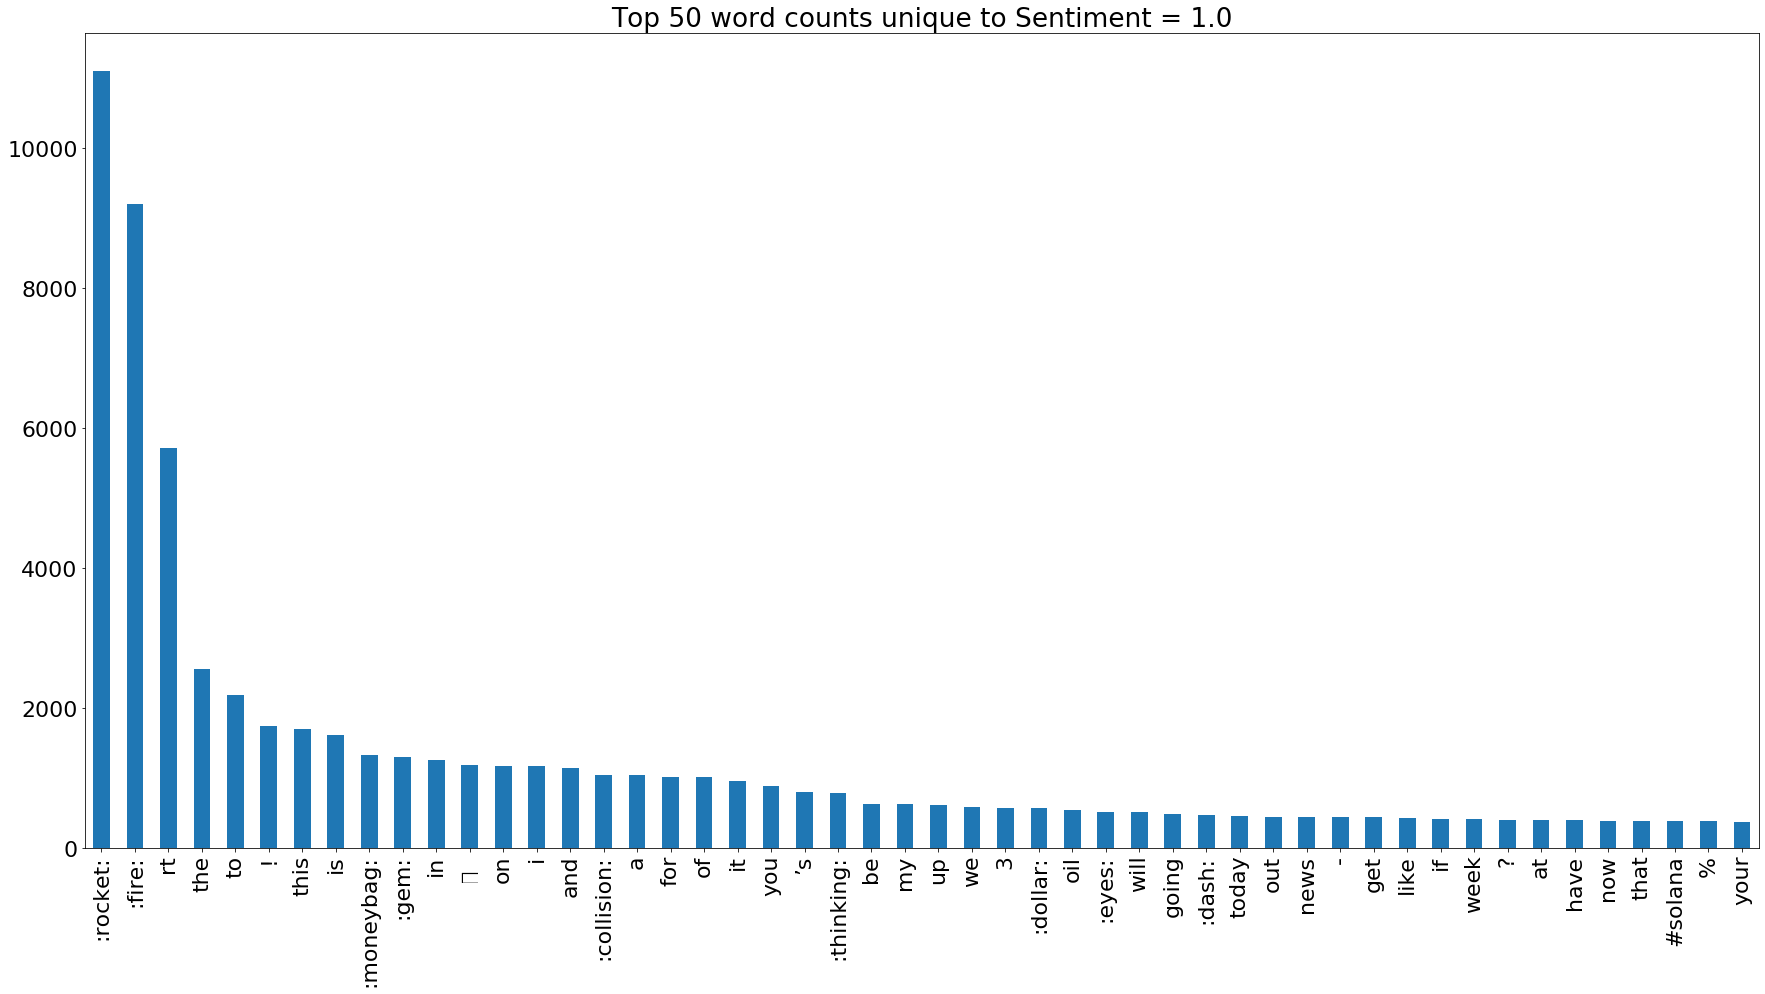

Top 50 words sort of unique to Sentiment = -1.0
['the', 'to', 'i', 'a', 'and', 'it', 'is', 'offering', 'rt', 'this', 'you', 'of', 'for', 'on', 'at', 'in', 'that', 'be', 'out', 'are', 'stock', 'like', 'seachange', 'but', '?', 'my', 'all', 'now', 'an', 'as', 'news', 'they', '!', 'not', 'what', '-', 'up', '’s', 'just', 'no', 'have', '%', 'get', 'will', "'s", 'day', 'with', 'dump', 'if', 'today']



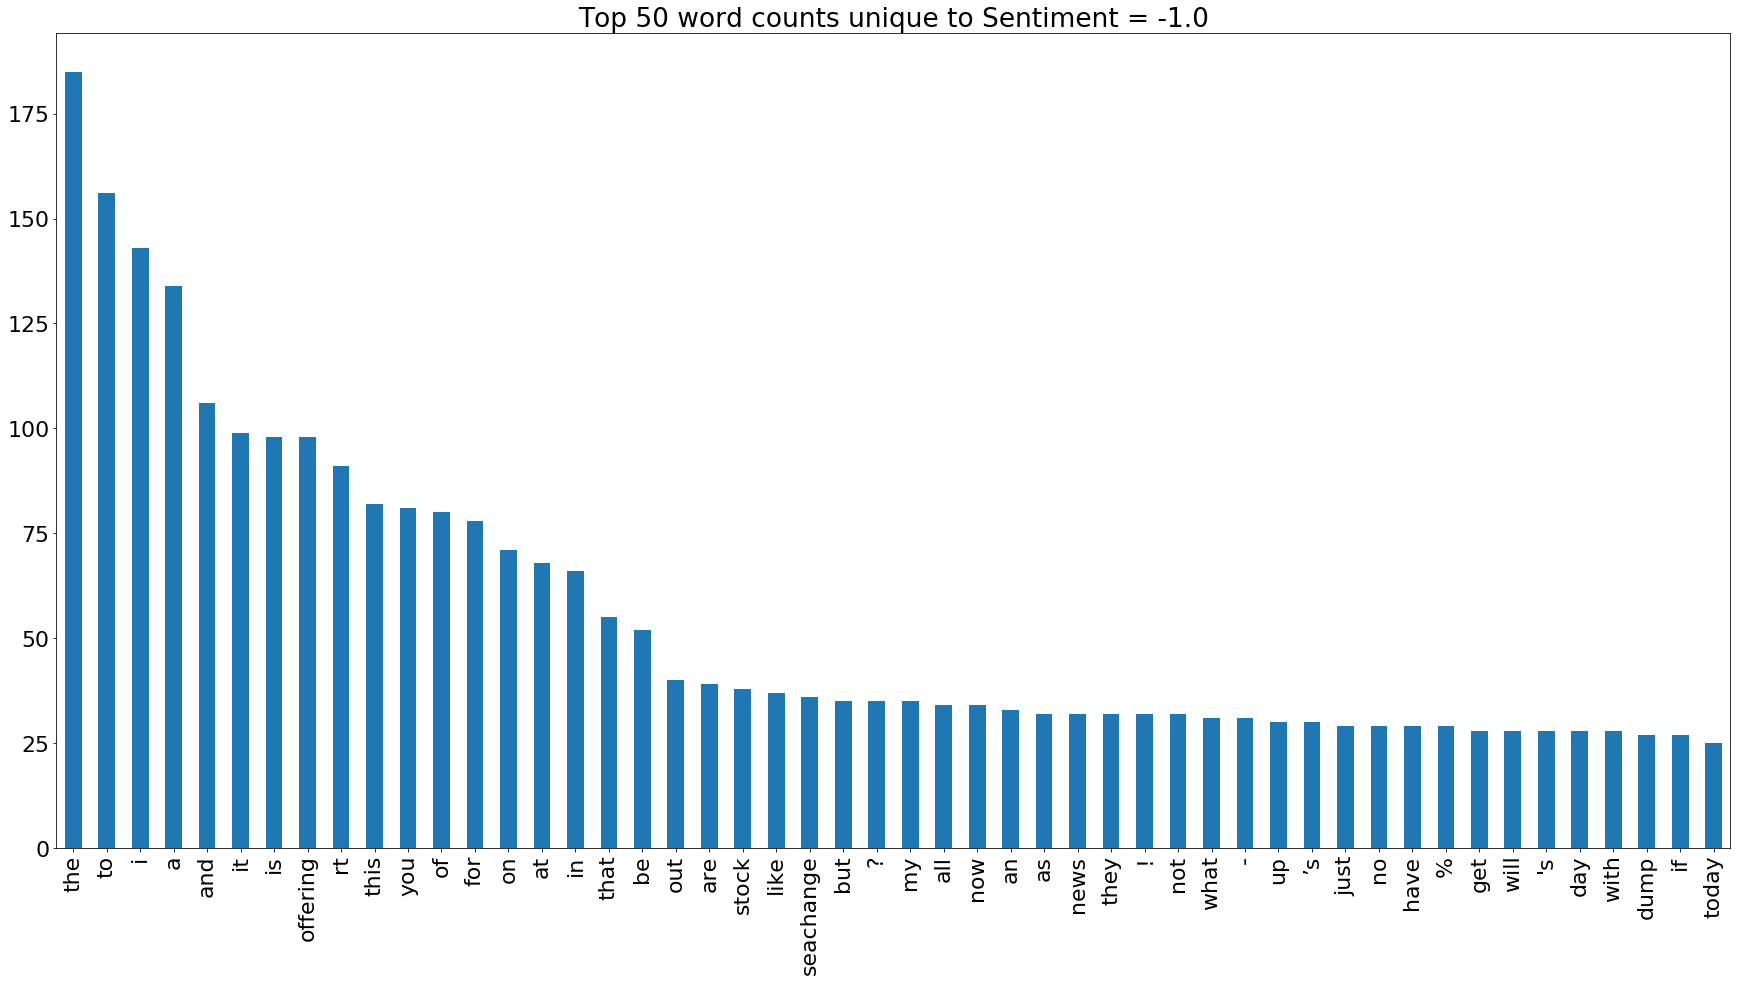

In [37]:
top_words(train_data, 'text_dec', 'Sentiment', 50)

Labels for Inflection_Point:
[ 1. -1.]
Top 50 words sort of unique to Inflection_Point = 1.0
[':rocket:', ':fire:', 'rt', '!', 'to', 'the', ':moneybag:', 'is', '1', 'current', 'this', 'on', '2', 'you', 'oil', '4', '-', 'of', '3', 'list', 'and', 'my', 'for', 'i', ':gem:', 'monday', ':dollar:', 'in', 'gold', '’s', 'excited', '&amp;', 'merger', 'fuck', 'cheap', 'top', ':eyes:', 'jane', 'week', '🛢', 'quie', '?', 'a', 'up', 'what', 'be', 'like', 'out', 'will', 'it']



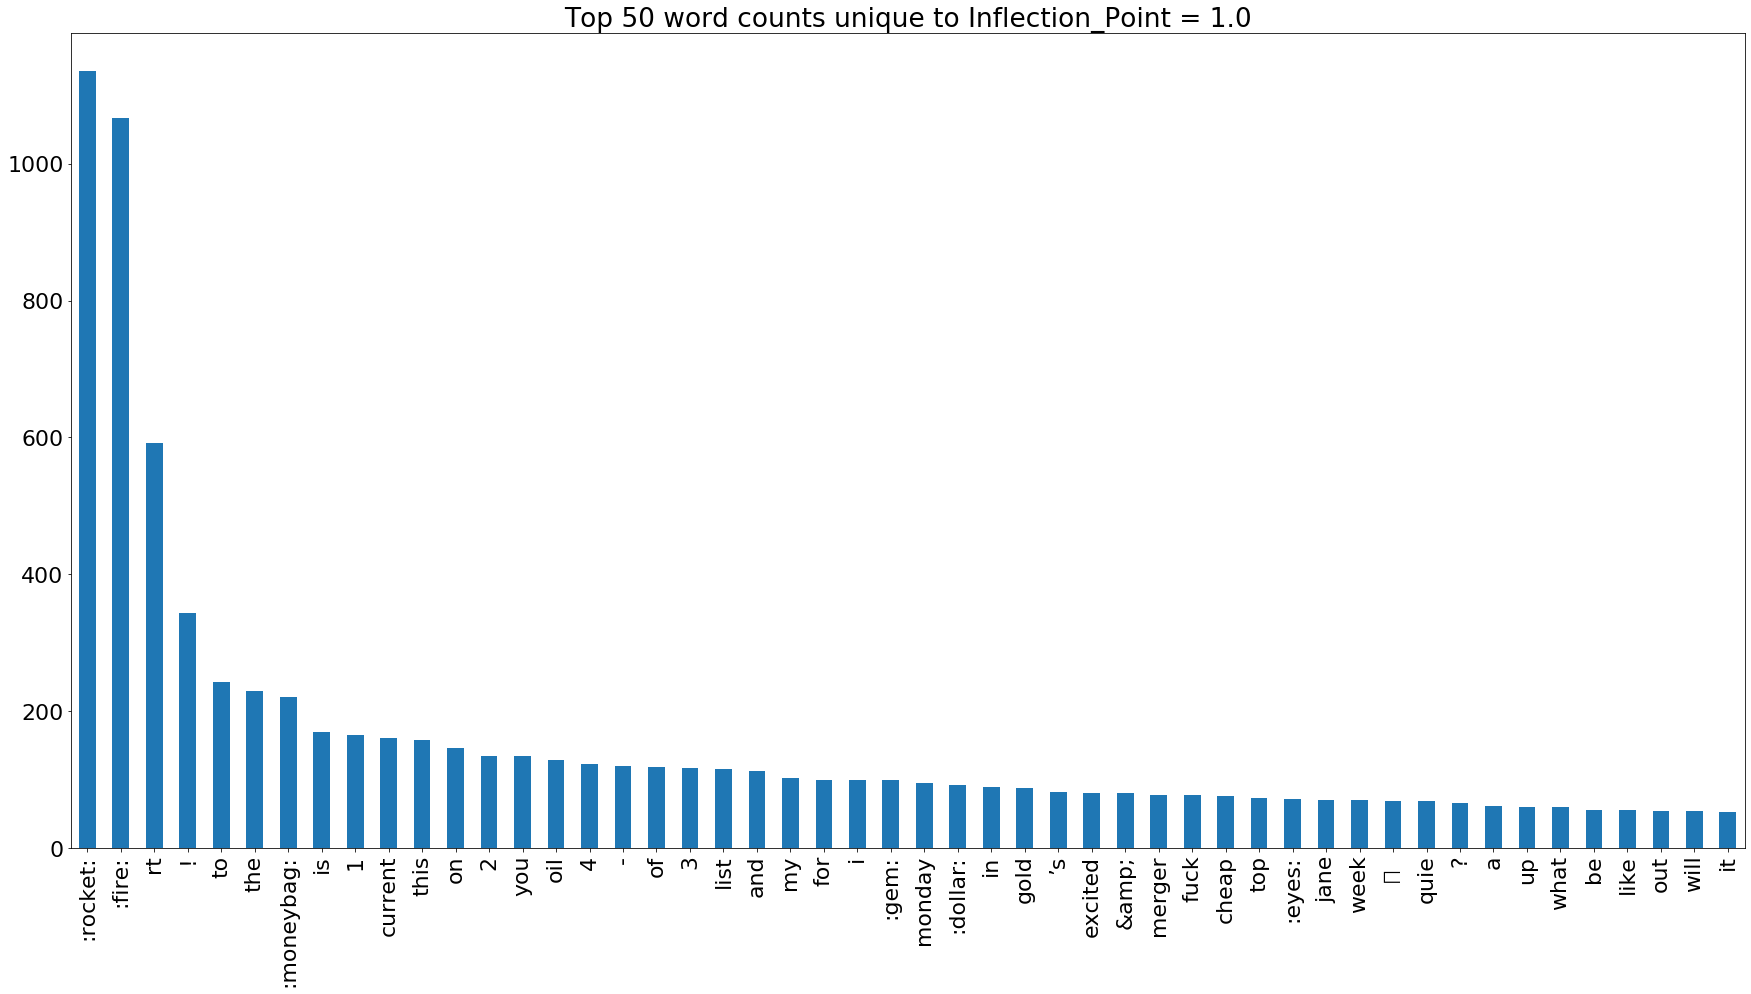

Top 50 words sort of unique to Inflection_Point = -1.0
['the', 'to', 'offering', 'a', 'i', 'of', 'it', 'rt', 'and', 'is', 'you', 'this', 'have', 'public', 'into', 'proposed', 'at', 'be', 'in', 'for', 'just', 'on', 'they', 'that', 'what', 'announces', 'stock', 'no', 'common', 'fuck', 'news', 'underwritten', 'so', 'seachange', 'all', 'too', 'us', 'these', 'international', '8', 'equipment', 'can', 'hope', 'up', '!', 'our', '#jane', 'come', 'mms', 'as']



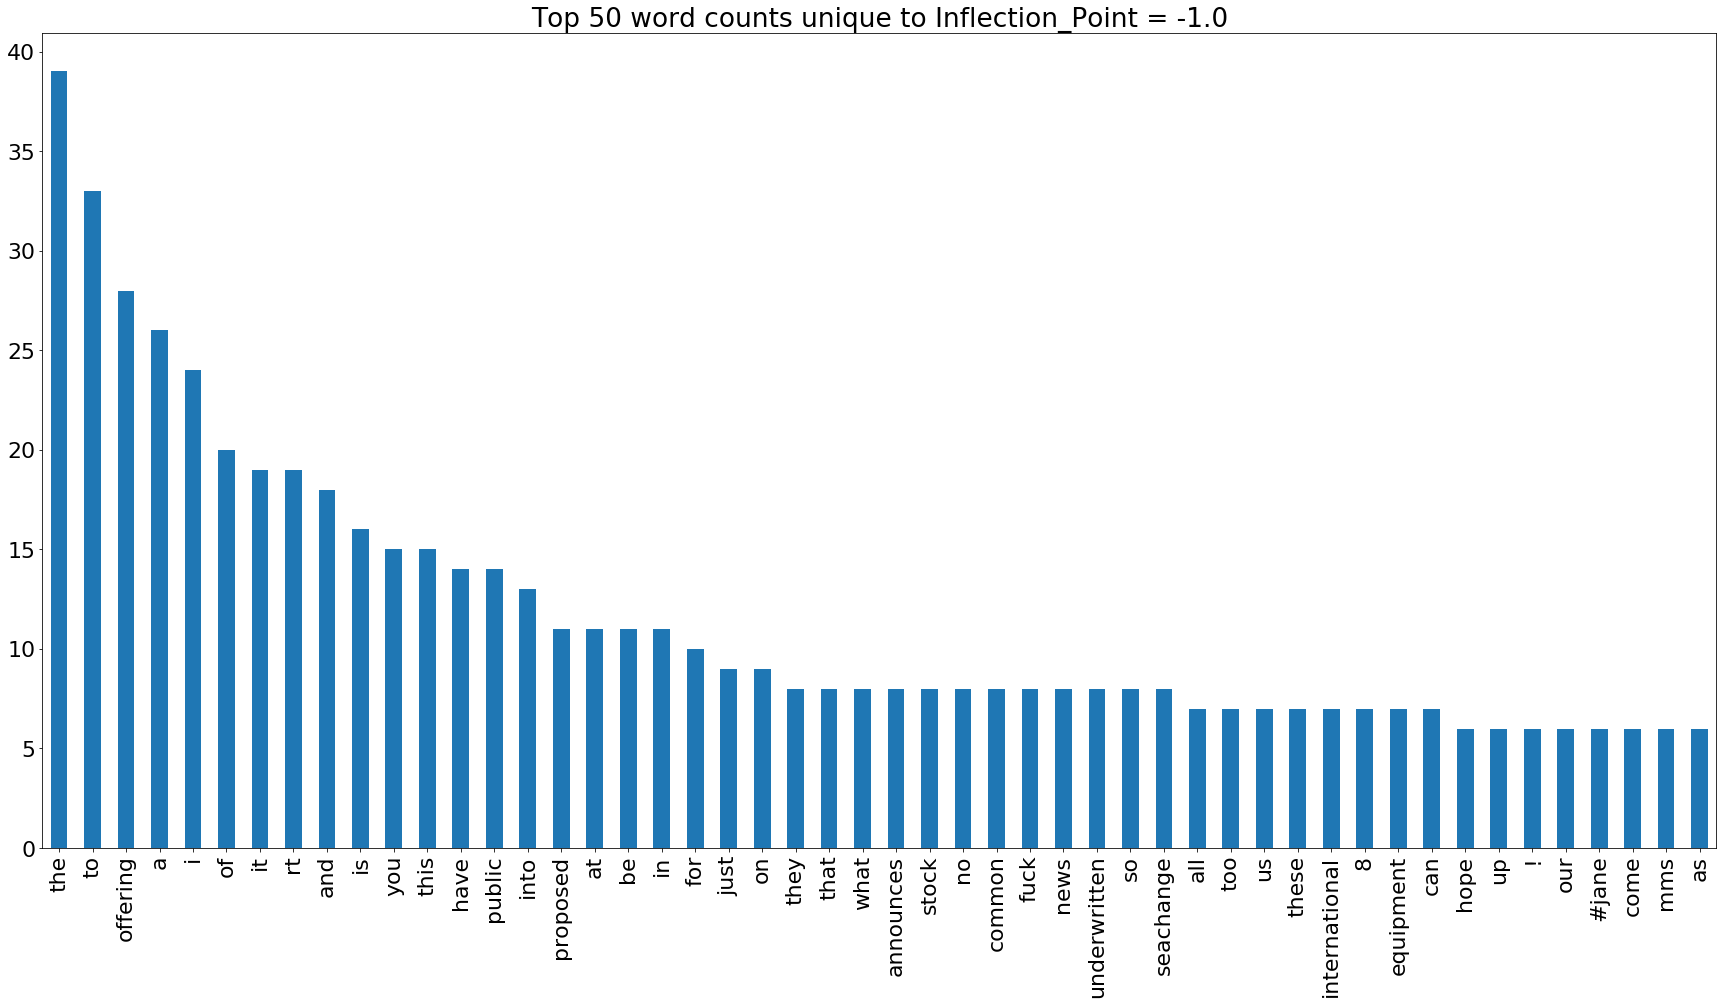

In [38]:
top_words(train_data, 'text_dec', 'Inflection_Point', 50)

In [39]:
reg_ex_tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+|:[a-z]+:')
vectorizer = CountVectorizer(stop_words='english', token_pattern='\w+|\$[\d\.]+|\S+|:[a-z]+:', min_df=100, strip_accents='ascii')
train_data_vec = vectorizer.fit_transform(train_data['text_dec'])
print("Count vector shape of X_train: {}".format(train_data.shape))

# Code for adding feature back on df 
count_vect_df = pd.DataFrame(train_data_vec.todense(), columns=vectorizer.get_feature_names())
train_data_cv = pd.concat([train_data, count_vect_df], axis=1)
# train_data_cv = train_data_cv.dropna(subset=['Sentiment'])
train_data_cv.head()

Count vector shape of X_train: (11189, 10)


,text,entities.hashtags,Sentiment,Price_Region,Inflection_Point,Known_Pumper,exc_count,characters_nb,emoji_count,text_dec,!,!!,!!!,!!!!,#,#88e,#nft,#solana,$,%,&amp;,'s,'t,),+,-,/30()19,1,10,1010,2,20,250,3,4,5,7000,:,:bangbang:,:chart_with_upwards_trend:,:collision:,:dollar:,:eyes:,:fire:,:gem:,:joy:,:money_mouth_face:,:moneybag:,:muscle:,:pray:,:rocket:,:rotating_light:,:slot_machine:,:smirk:,:sunglasses:,:white_check_mark:,?,ath,baby,big,bought,buy,check,come,coming,company,current,day,days,dd,dip,dont,early,energy,excited,float,ftx,fuck,going,gold,gonna,good,got,great,green,high,hit,hold,holding,hope,huge,im,just,know,let,lets,like,list,long,looking,market,mil,million,monday,money,moon,morning,need,new,news,nice,oil,otc,penny,people,pink,play,post,price,read,ready,right,rt,run,shares,short,soon,squeeze,stock,stocks,support,think,time,today,tomorrow,tweet,update,volume,week,weekend,world,year,youre
0,#rt rt new intern ceo,"[{'text': 'RT', 'indices': [0, 3]}]",0.0,1.0,NaN,0.0,0,73,0,#rt rt new intern ceo,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,rt #rt rt new intern ceo,"[{'text': 'RT', 'indices': [13, 16]}]",0.0,1.0,NaN,0.0,0,86,0,rt #rt rt new intern ceo,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,big otc % gainer!🚀🚀🚀,[],1.0,1.0,NaN,0.0,1,21,3,big otc % gainer! :rocket: :rocket: :rocket:,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,today’s top penny stock gainers #pennystocks,"[{'text': 'pennystocks', 'indices': [93, 105]}]",1.0,1.0,NaN,0.0,0,56,0,today’s top penny stock gainers #pennystocks,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,rt today’s top penny stock gainers #pennystocks #hotstocks #otcbb #,"[{'text': 'pennystocks', 'indices': [107, 119]}, {'text': 'hotstocks', 'indices': [120, 130]}, {'text': 'otcbb', 'indices': [131, 137]}]",1.0,1.0,NaN,0.0,0,89,0,rt today’s top penny stock gainers #pennystocks #hotstocks #otcbb #,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [40]:
print(train_data_cv['Sentiment'].unique())
train_data_cv[train_data_cv.isna()].head()

[ 0.  1. -1.]


,text,entities.hashtags,Sentiment,Price_Region,Inflection_Point,Known_Pumper,exc_count,characters_nb,emoji_count,text_dec,!,!!,!!!,!!!!,#,#88e,#nft,#solana,$,%,&amp;,'s,'t,),+,-,/30()19,1,10,1010,2,20,250,3,4,5,7000,:,:bangbang:,:chart_with_upwards_trend:,:collision:,:dollar:,:eyes:,:fire:,:gem:,:joy:,:money_mouth_face:,:moneybag:,:muscle:,:pray:,:rocket:,:rotating_light:,:slot_machine:,:smirk:,:sunglasses:,:white_check_mark:,?,ath,baby,big,bought,buy,check,come,coming,company,current,day,days,dd,dip,dont,early,energy,excited,float,ftx,fuck,going,gold,gonna,good,got,great,green,high,hit,hold,holding,hope,huge,im,just,know,let,lets,like,list,long,looking,market,mil,million,monday,money,moon,morning,need,new,news,nice,oil,otc,penny,people,pink,play,post,price,read,ready,right,rt,run,shares,short,soon,squeeze,stock,stocks,support,think,time,today,tomorrow,tweet,update,volume,week,weekend,world,year,youre
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
X_train, X_test, Y_train, Y_test = train_test_split(train_data.drop(['Sentiment'], axis=1), train_data['Sentiment'], test_size=1/4.0, random_state=0)

In [42]:
X_train = X_train[['exc_count', 'characters_nb', 'emoji_count']]
X_test = X_test[['exc_count', 'characters_nb', 'emoji_count']]
X_train.head()

,exc_count,characters_nb,emoji_count
9752,0,108,6
7460,0,132,2
627,0,13,1
2189,0,85,2
6914,0,57,0


In [43]:
Y_train.head()

9752    1.0
7460    1.0
627     1.0
2189    1.0
6914   -1.0
Name: Sentiment, dtype: float64

In [44]:
# Define models to test
models = [
          ('LogReg', LogisticRegression()), 
          ('RF', RandomForestClassifier()),
          ('KNN', KNeighborsClassifier()),
          ('SVM', SVC()), 
          ('GNB', GaussianNB())
        ]

In [45]:
for name, model in models:
    print(name)
    kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=90210)
    cv_results = model_selection.cross_validate(model, X_train, Y_train, cv=kfold)
    clf = model.fit(X_train, Y_train)
    y_pred = clf.predict(X_test)
    
    print(accuracy_score(Y_test, y_pred))

LogReg


C:\Users\GeorgeE\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\GeorgeE\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stabl

0.8859899928520372
RF
0.8895639742673338
KNN
0.8888491779842744
SVM
0.8859899928520372
GNB
0.852037169406719


In [46]:
# Now trying with countvectorizer
X_train, X_test, Y_train, Y_test = train_test_split(train_data_cv.loc[:, '!':], train_data_cv['Sentiment'], test_size=1/4.0, random_state=0)

In [47]:
X_train.head()

,!,!!,!!!,!!!!,#,#88e,#nft,#solana,$,%,&amp;,'s,'t,),+,-,/30()19,1,10,1010,2,20,250,3,4,5,7000,:,:bangbang:,:chart_with_upwards_trend:,:collision:,:dollar:,:eyes:,:fire:,:gem:,:joy:,:money_mouth_face:,:moneybag:,:muscle:,:pray:,:rocket:,:rotating_light:,:slot_machine:,:smirk:,:sunglasses:,:white_check_mark:,?,ath,baby,big,bought,buy,check,come,coming,company,current,day,days,dd,dip,dont,early,energy,excited,float,ftx,fuck,going,gold,gonna,good,got,great,green,high,hit,hold,holding,hope,huge,im,just,know,let,lets,like,list,long,looking,market,mil,million,monday,money,moon,morning,need,new,news,nice,oil,otc,penny,people,pink,play,post,price,read,ready,right,rt,run,shares,short,soon,squeeze,stock,stocks,support,think,time,today,tomorrow,tweet,update,volume,week,weekend,world,year,youre
9752,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7460,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
627,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2189,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6914,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [48]:
# Adding scaling - not added yet but leaving here for now
from sklearn.preprocessing import MinMaxScaler

In [49]:
# x_scaled = MinMaxScaler().fit_transform(X_train)
# df = pd.DataFrame(x_scaled)
# df.head()

In [50]:
for name, model in models:
    print(name)
    kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=90210)
    cv_results = model_selection.cross_validate(model, X_train, Y_train, cv=kfold)
    clf = model.fit(X_train, Y_train)
    y_pred = clf.predict(X_test)
    
    print(accuracy_score(Y_test, y_pred))

LogReg
0.8927805575411007
RF
0.8984989278055754
KNN
0.8927805575411007
SVM
0.8899213724088635
GNB
0.4224446032880629


In [51]:
# Trying TfiDf
vectorizer = TfidfVectorizer(stop_words='english', token_pattern='\w+|\$[\d\.]+|\S+|:[a-z]+:', min_df=100, strip_accents='ascii')
train_data_vec = vectorizer.fit_transform(train_data['text_dec'])
print("Count vector shape of X_train: {}".format(train_data.shape))

# Code for adding feature back on df 
count_vect_df = pd.DataFrame(train_data_vec.todense(), columns=vectorizer.get_feature_names())
train_data_tf = pd.concat([train_data, count_vect_df], axis=1)
train_data_tf = train_data_tf.dropna(subset=['Sentiment'])
train_data_tf.head()

Count vector shape of X_train: (11189, 10)


,text,entities.hashtags,Sentiment,Price_Region,Inflection_Point,Known_Pumper,exc_count,characters_nb,emoji_count,text_dec,!,!!,!!!,!!!!,#,#88e,#nft,#solana,$,%,&amp;,'s,'t,),+,-,/30()19,1,10,1010,2,20,250,3,4,5,7000,:,:bangbang:,:chart_with_upwards_trend:,:collision:,:dollar:,:eyes:,:fire:,:gem:,:joy:,:money_mouth_face:,:moneybag:,:muscle:,:pray:,:rocket:,:rotating_light:,:slot_machine:,:smirk:,:sunglasses:,:white_check_mark:,?,ath,baby,big,bought,buy,check,come,coming,company,current,day,days,dd,dip,dont,early,energy,excited,float,ftx,fuck,going,gold,gonna,good,got,great,green,high,hit,hold,holding,hope,huge,im,just,know,let,lets,like,list,long,looking,market,mil,million,monday,money,moon,morning,need,new,news,nice,oil,otc,penny,people,pink,play,post,price,read,ready,right,rt,run,shares,short,soon,squeeze,stock,stocks,support,think,time,today,tomorrow,tweet,update,volume,week,weekend,world,year,youre
0,#rt rt new intern ceo,"[{'text': 'RT', 'indices': [0, 3]}]",0.0,1.0,NaN,0.0,0,73,0,#rt rt new intern ceo,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.941780,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.336228,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,rt #rt rt new intern ceo,"[{'text': 'RT', 'indices': [13, 16]}]",0.0,1.0,NaN,0.0,0,86,0,rt #rt rt new intern ceo,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.813833,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.581099,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,big otc % gainer!🚀🚀🚀,[],1.0,1.0,NaN,0.0,1,21,3,big otc % gainer! :rocket: :rocket: :rocket:,0.28251,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.391465,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.54874,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.477108,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.488053,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,today’s top penny stock gainers #pennystocks,"[{'text': 'pennystocks', 'indices': [93, 105]}]",1.0,1.0,NaN,0.0,0,56,0,today’s top penny stock gainers #pennystocks,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.760319,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.649549,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,rt today’s top penny stock gainers #pennystocks #hotstocks #otcbb #,"[{'text': 'pennystocks', 'indices': [107, 119]}, {'text': 'hotstocks', 'indices': [120, 130]}, {'text': 'otcbb', 'indices': [131, 137]}]",1.0,1.0,NaN,0.0,0,89,0,rt today’s top penny stock gainers #pennystocks #hot

In [52]:
# Now trying with countvectorizer
X_train, X_test, Y_train, Y_test = train_test_split(train_data_tf.loc[:, '!':], train_data_tf['Sentiment'], test_size=1/4.0, random_state=0)

In [53]:
for name, model in models:
    print(name)
    kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=90210)
    cv_results = model_selection.cross_validate(model, X_train, Y_train, cv=kfold)
    clf = model.fit(X_train, Y_train)
    y_pred = clf.predict(X_test)
    
    print(accuracy_score(Y_test, y_pred))

LogReg
0.8956397426733381
RF
0.8995711222301644
KNN
0.8881343817012152
SVM
0.9002859185132237
GNB
0.31165117941386705


## Matt's code

In [54]:
import nltk
from collections import Counter

In [55]:
# Matt's code
stopwords = nltk.corpus.stopwords.words('english')
RE_stopwords = r'\b(?:{})\b'.format('|'.join(stopwords))
textWords = (train_data.text.str.lower().replace([r'\|', RE_stopwords], [' ', ''], regex=True).str.cat(sep=' ').split())
textRslt = pd.DataFrame(Counter(textWords).most_common(100), columns=['Word', 'Frequency']).set_index('Word')

In [56]:
textRslt.head(50)

,Frequency
Word,
rt,5984
’,1315
🚀,1289
🔥,1040
going,501
-,478
news,473
like,469
',465


# Creating pipeline 

In [57]:
import vocab

In [58]:
vocab_list = vocab.get_all_vocab()
print(vocab_list)

['news', 'update', 'alert', 'company', '2021', 'available', '#stocks', 'free', ':brain:', 'hold', ':rocket:', ':fire:', 'rocket', ':moneybag:', 'buy', ':pray:', ':dollar:', 'moon', ':bangbang:', ':gem:', ':slot_machine:house', 'rich', ':eyes:', ':collision:', 'ath', 'offering', 'dump', 'short', 'public', 'proposed', 'down', 'red', 'dip', 'diamond', 'pump and dump', 'out', 'sell', 'sold', 'current', 'list', 'gold', 'excited', 'cheap', 'merger', 'bad', 'underwritten', 'wait', 'see', 'annouces', 'profit']


In [59]:
def add_features():
    return None

In [60]:
def apply_countvectorizer(df, text_col, min_df=1, vocab_def=None):
    vectorizer = CountVectorizer(stop_words='english', token_pattern='\w+|\$[\d\.]+|\S+|:[a-z]+:', min_df=min_df, strip_accents='ascii', vocabulary=vocab_def)
    train_data_vec = vectorizer.fit_transform(df[text_col])
    print("Count vector shape of vectorized data: {}".format(train_data_vec.shape))
    # Code for adding feature back on df 
    count_vect_df = pd.DataFrame(train_data_vec.todense(), columns=vectorizer.get_feature_names())
    train_data_cv = pd.concat([df, count_vect_df], axis=1)
    return train_data_cv

In [61]:
def apply_tfidf(df, text_col, min_df=1, vocab_def=None):
    vectorizer = TfidfVectorizer(stop_words='english', token_pattern='\w+|\$[\d\.]+|\S+|:[a-z]+:', min_df=min_df, strip_accents='ascii', vocabulary=vocab_def)
    train_data_vec = vectorizer.fit_transform(df[text_col])
    print("Count vector shape of vectorized data: {}".format(train_data_vec.shape))
    # Code for adding feature back on df 
    count_vect_df = pd.DataFrame(train_data_vec.todense(), columns=vectorizer.get_feature_names())
    train_data_tf = pd.concat([df, count_vect_df], axis=1)
    return train_data_tf

In [62]:
def run_models(model_list, X_train, X_test, Y_train, Y_test, labels=None):
    for name, model in model_list:
        print(name)
        kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=90210)
        cv_results = model_selection.cross_validate(model, X_train, Y_train, cv=kfold)
        clf = model.fit(X_train, Y_train)
        y_pred = clf.predict(X_test)
        print(accuracy_score(Y_test, y_pred))
        plot_confusion_matrix(clf, X_test, Y_test)
        plt.show()
        print(classification_report(Y_test, y_pred, labels=labels))

In [63]:
train_cv_vocab = apply_countvectorizer(train_data, 'text_dec', vocab_def=vocab_list)
train_cv_vocab.head()

Count vector shape of vectorized data: (11189, 50)


,text,entities.hashtags,Sentiment,Price_Region,Inflection_Point,Known_Pumper,exc_count,characters_nb,emoji_count,text_dec,news,update,alert,company,2021,available,#stocks,free,:brain:,hold,:rocket:,:fire:,rocket,:moneybag:,buy,:pray:,:dollar:,moon,:bangbang:,:gem:,:slot_machine:house,rich,:eyes:,:collision:,ath,offering,dump,short,public,proposed,down,red,dip,diamond,pump and dump,out,sell,sold,current,list,gold,excited,cheap,merger,bad,underwritten,wait,see,annouces,profit
0,#rt rt new intern ceo,"[{'text': 'RT', 'indices': [0, 3]}]",0.0,1.0,NaN,0.0,0,73,0,#rt rt new intern ceo,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,rt #rt rt new intern ceo,"[{'text': 'RT', 'indices': [13, 16]}]",0.0,1.0,NaN,0.0,0,86,0,rt #rt rt new intern ceo,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,big otc % gainer!🚀🚀🚀,[],1.0,1.0,NaN,0.0,1,21,3,big otc % gainer! :rocket: :rocket: :rocket:,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,today’s top penny stock gainers #pennystocks,"[{'text': 'pennystocks', 'indices': [93, 105]}]",1.0,1.0,NaN,0.0,0,56,0,today’s top penny stock gainers #pennystocks,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,rt today’s top penny stock gainers #pennystocks #hotstocks #otcbb #,"[{'text': 'pennystocks', 'indices': [107, 119]}, {'text': 'hotstocks', 'indices': [120, 130]}, {'text': 'otcbb', 'indices': [131, 137]}]",1.0,1.0,NaN,0.0,0,89,0,rt today’s top penny stock gainers #pennystocks #hotstocks #otcbb #,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [64]:
train_cv_vocab.dropna(subset=['Sentiment'], inplace=True)
train_cv_vocab['Sentiment'].unique()

array([ 0.,  1., -1.])

In [65]:
train_tf_vocab = apply_tfidf(train_data, 'text_dec', vocab_def=vocab_list)
train_tf_vocab.head()

Count vector shape of vectorized data: (11189, 50)


,text,entities.hashtags,Sentiment,Price_Region,Inflection_Point,Known_Pumper,exc_count,characters_nb,emoji_count,text_dec,news,update,alert,company,2021,available,#stocks,free,:brain:,hold,:rocket:,:fire:,rocket,:moneybag:,buy,:pray:,:dollar:,moon,:bangbang:,:gem:,:slot_machine:house,rich,:eyes:,:collision:,ath,offering,dump,short,public,proposed,down,red,dip,diamond,pump and dump,out,sell,sold,current,list,gold,excited,cheap,merger,bad,underwritten,wait,see,annouces,profit
0,#rt rt new intern ceo,"[{'text': 'RT', 'indices': [0, 3]}]",0.0,1.0,NaN,0.0,0,73,0,#rt rt new intern ceo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,rt #rt rt new intern ceo,"[{'text': 'RT', 'indices': [13, 16]}]",0.0,1.0,NaN,0.0,0,86,0,rt #rt rt new intern ceo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,big otc % gainer!🚀🚀🚀,[],1.0,1.0,NaN,0.0,1,21,3,big otc % gainer! :rocket: :rocket: :rocket:,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,today’s top penny stock gainers #pennystocks,"[{'text': 'pennystocks', 'indices': [93, 105]}]",1.0,1.0,NaN,0.0,0,56,0,today’s top penny stock gainers #pennystocks,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,rt today’s top penny stock gainers #pennystocks #hotstocks #otcbb #,"[{'text': 'pennystocks', 'indices': [107, 119]}, {'text': 'hotstocks', 'indices': [120, 130]}, {'text': 'otcbb', 'indices': [131, 137]}]",1.0,1.0,NaN,0.0,0,89,0,rt today’s top penny stock gainers #pennystocks #hotstocks #otcbb #,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [66]:
train_tf_vocab.dropna(subset=['Sentiment'], inplace=True)
train_tf_vocab['Sentiment'].unique()
train_tf_vocab[train_tf_vocab.isna()].head()

,text,entities.hashtags,Sentiment,Price_Region,Inflection_Point,Known_Pumper,exc_count,characters_nb,emoji_count,text_dec,news,update,alert,company,2021,available,#stocks,free,:brain:,hold,:rocket:,:fire:,rocket,:moneybag:,buy,:pray:,:dollar:,moon,:bangbang:,:gem:,:slot_machine:house,rich,:eyes:,:collision:,ath,offering,dump,short,public,proposed,down,red,dip,diamond,pump and dump,out,sell,sold,current,list,gold,excited,cheap,merger,bad,underwritten,wait,see,annouces,profit
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [67]:
X_train_cv, X_test_cv, Y_train_cv, Y_test_cv = train_test_split(train_cv_vocab.loc[:, 'news':], train_cv_vocab['Sentiment'], test_size=1/4.0, random_state=0)

LogReg
0.9013581129378128


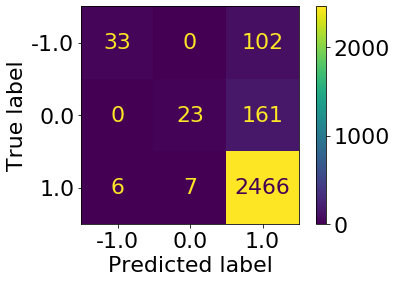

              precision    recall  f1-score   support

        -1.0       0.85      0.24      0.38       135
         0.0       0.77      0.12      0.21       184
         1.0       0.90      0.99      0.95      2479

    accuracy                           0.90      2798
   macro avg       0.84      0.45      0.51      2798
weighted avg       0.89      0.90      0.87      2798

RF
0.902072909220872


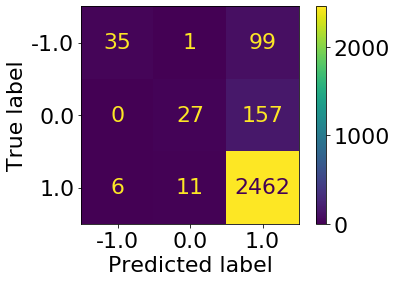

              precision    recall  f1-score   support

        -1.0       0.85      0.26      0.40       135
         0.0       0.69      0.15      0.24       184
         1.0       0.91      0.99      0.95      2479

    accuracy                           0.90      2798
   macro avg       0.82      0.47      0.53      2798
weighted avg       0.89      0.90      0.87      2798

KNN
0.899928520371694


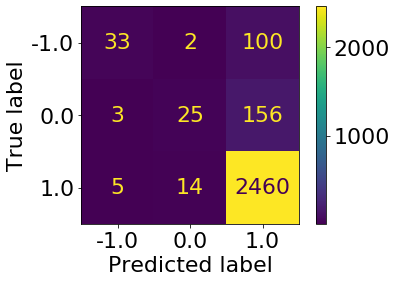

              precision    recall  f1-score   support

        -1.0       0.80      0.24      0.38       135
         0.0       0.61      0.14      0.22       184
         1.0       0.91      0.99      0.95      2479

    accuracy                           0.90      2798
   macro avg       0.77      0.46      0.51      2798
weighted avg       0.88      0.90      0.87      2798

SVM
0.9002859185132237


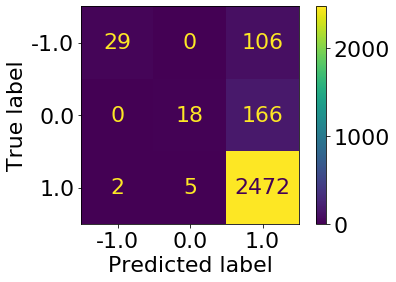

              precision    recall  f1-score   support

        -1.0       0.94      0.21      0.35       135
         0.0       0.78      0.10      0.17       184
         1.0       0.90      1.00      0.95      2479

    accuracy                           0.90      2798
   macro avg       0.87      0.44      0.49      2798
weighted avg       0.89      0.90      0.87      2798

GNB
0.3745532523230879


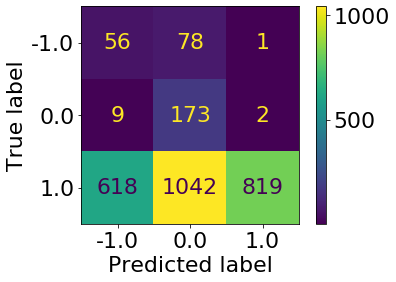

              precision    recall  f1-score   support

        -1.0       0.08      0.41      0.14       135
         0.0       0.13      0.94      0.23       184
         1.0       1.00      0.33      0.50      2479

    accuracy                           0.37      2798
   macro avg       0.40      0.56      0.29      2798
weighted avg       0.90      0.37      0.46      2798



In [68]:
# Testing countvectorizer with specified words
run_models(models, X_train_cv, X_test_cv, Y_train_cv, Y_test_cv)

In [69]:
X_train_tf, X_test_tf, Y_train_tf, Y_test_tf = train_test_split(train_tf_vocab.loc[:, 'news':], train_tf_vocab['Sentiment'], test_size=1/4.0, random_state=0)

LogReg
0.902072909220872


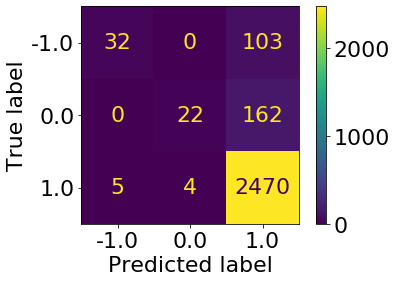

              precision    recall  f1-score   support

        -1.0       0.86      0.24      0.37       135
         0.0       0.85      0.12      0.21       184
         1.0       0.90      1.00      0.95      2479

    accuracy                           0.90      2798
   macro avg       0.87      0.45      0.51      2798
weighted avg       0.90      0.90      0.87      2798

RF
0.9010007147962831


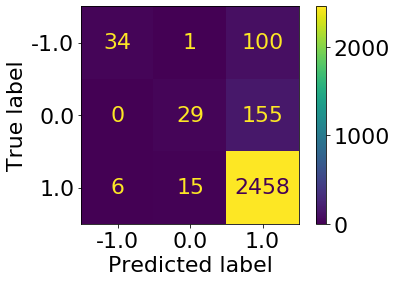

              precision    recall  f1-score   support

        -1.0       0.85      0.25      0.39       135
         0.0       0.64      0.16      0.25       184
         1.0       0.91      0.99      0.95      2479

    accuracy                           0.90      2798
   macro avg       0.80      0.47      0.53      2798
weighted avg       0.89      0.90      0.87      2798

KNN
0.7787705503931379


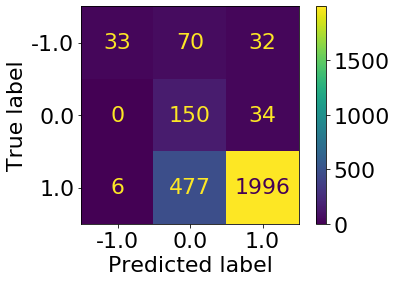

              precision    recall  f1-score   support

        -1.0       0.85      0.24      0.38       135
         0.0       0.22      0.82      0.34       184
         1.0       0.97      0.81      0.88      2479

    accuracy                           0.78      2798
   macro avg       0.68      0.62      0.53      2798
weighted avg       0.91      0.78      0.82      2798

SVM
0.9035025017869907


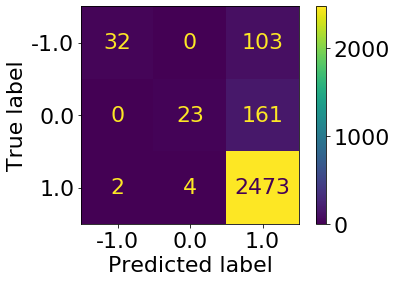

              precision    recall  f1-score   support

        -1.0       0.94      0.24      0.38       135
         0.0       0.85      0.12      0.22       184
         1.0       0.90      1.00      0.95      2479

    accuracy                           0.90      2798
   macro avg       0.90      0.45      0.51      2798
weighted avg       0.90      0.90      0.87      2798

GNB
0.4006433166547534


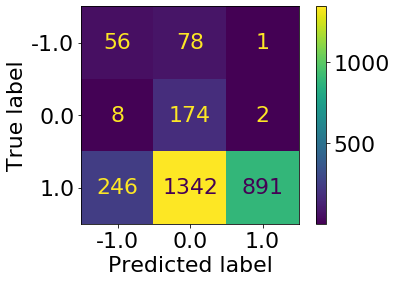

              precision    recall  f1-score   support

        -1.0       0.18      0.41      0.25       135
         0.0       0.11      0.95      0.20       184
         1.0       1.00      0.36      0.53      2479

    accuracy                           0.40      2798
   macro avg       0.43      0.57      0.33      2798
weighted avg       0.90      0.40      0.49      2798



In [70]:
# Testing countvectorizer with specified words
run_models(models, X_train_tf, X_test_tf, Y_train_tf, Y_test_tf)

# Sample the data for a more even split

In [71]:
# See how many negative values we have
train_data[train_data['Sentiment'] == -1].shape

(500, 10)

In [72]:
train_data[train_data['Sentiment'] == 0].shape

(727, 10)

In [73]:
neg_sent = train_data[train_data['Sentiment'] == -1]
pos_sent = train_data[train_data['Sentiment'] == 1].sample(neg_sent.shape[0])
neut_sent = train_data[train_data['Sentiment'] == 0].sample(neg_sent.shape[0])

In [74]:
print(pos_sent.shape)

(500, 10)


In [75]:
train_data_sample = neg_sent.append(pos_sent, ignore_index=True)
#train_data_sample = train_data_sample.append(neut_sent, ignore_index=True)
train_data_sample.shape

(1000, 10)

In [76]:
train_data_sample.head()

,text,entities.hashtags,Sentiment,Price_Region,Inflection_Point,Known_Pumper,exc_count,characters_nb,emoji_count,text_dec
0,💎💎💣💣🚀🚀🔒,[],-1.0,-1.0,NaN,0.0,0,9,7,:gem: :gem: :bomb: :bomb: :rocket: :rocket: :lock:
1,rt red day my main longs all had pullback today and was able to come out positive in dah trading,[],-1.0,-1.0,NaN,0.0,0,114,0,rt red day my main longs all had pullback today and was able to come out positive in dah trading
2,rt red day my main longs all had pullback today and was able to come out positive in dah trading,[],-1.0,-1.0,NaN,0.0,0,114,0,rt red day my main longs all had pullback today and was able to come out positive in dah trading
3,*sees stocks are mostly red again today* “welp see ya later ✌🏽”,[],-1.0,-1.0,NaN,0.0,0,70,0,*sees stocks are mostly red again today* “welp see ya later ✌🏽”
4,who keeps selling on the ask? that’s a special kind of stupid all you selling on the ask it’s stupid! anythin,[],-1.0,-1.0,NaN,0.0,1,111,0,who keeps selling on the ask? that’s a special kind of stupid all you selling on the ask it’s stupid! anythin


In [77]:
train_data_sample[train_data_sample['Sentiment'].isna()].shape

(0, 10)

In [78]:
train_tf_sample = apply_tfidf(train_data_sample, 'text_dec', vocab_def=vocab_list)

Count vector shape of vectorized data: (1000, 50)


In [79]:
train_tf_sample.head()

,text,entities.hashtags,Sentiment,Price_Region,Inflection_Point,Known_Pumper,exc_count,characters_nb,emoji_count,text_dec,news,update,alert,company,2021,available,#stocks,free,:brain:,hold,:rocket:,:fire:,rocket,:moneybag:,buy,:pray:,:dollar:,moon,:bangbang:,:gem:,:slot_machine:house,rich,:eyes:,:collision:,ath,offering,dump,short,public,proposed,down,red,dip,diamond,pump and dump,out,sell,sold,current,list,gold,excited,cheap,merger,bad,underwritten,wait,see,annouces,profit
0,💎💎💣💣🚀🚀🔒,[],-1.0,-1.0,NaN,0.0,0,9,7,:gem: :gem: :bomb: :bomb: :rocket: :rocket: :lock:,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4701,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.882613,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,rt red day my main longs all had pullback today and was able to come out positive in dah trading,[],-1.0,-1.0,NaN,0.0,0,114,0,rt red day my main longs all had pullback today and was able to come out positive in dah trading,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,rt red day my main longs all had pullback today and was able to come out positive in dah trading,[],-1.0,-1.0,NaN,0.0,0,114,0,rt red day my main longs all had pullback today and was able to come out positive in dah trading,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,*sees stocks are mostly red again today* “welp see ya later ✌🏽”,[],-1.0,-1.0,NaN,0.0,0,70,0,*sees stocks are mostly red again today* “welp see ya later ✌🏽”,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,who keeps selling on the ask? that’s a special kind of stupid all you selling on the ask it’s stupid! anythin,[],-1.0,-1.0,NaN,0.0,1,111,0,who keeps selling on the ask? that’s a special kind of stupid all you selling on the ask it’s stupid! anythin,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [80]:
X_train_tf, X_test_tf, Y_train_tf, Y_test_tf = train_test_split(train_tf_sample.loc[:, 'news':], train_tf_sample['Sentiment'], test_size=1/4.0, random_state=0)

LogReg
0.86


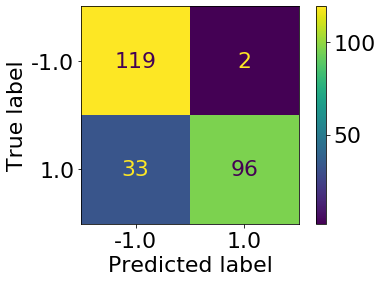

C:\Users\GeorgeE\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\GeorgeE\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\GeorgeE\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\

              precision    recall  f1-score   support

        -1.0       0.78      0.98      0.87       121
         0.0       0.00      0.00      0.00         0
         1.0       0.98      0.74      0.85       129

   micro avg       0.86      0.86      0.86       250
   macro avg       0.59      0.58      0.57       250
weighted avg       0.88      0.86      0.86       250

RF
0.856


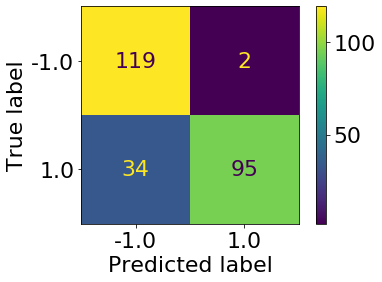

              precision    recall  f1-score   support

        -1.0       0.78      0.98      0.87       121
         0.0       0.00      0.00      0.00         0
         1.0       0.98      0.74      0.84       129

   micro avg       0.86      0.86      0.86       250
   macro avg       0.59      0.57      0.57       250
weighted avg       0.88      0.86      0.85       250

KNN


C:\Users\GeorgeE\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\GeorgeE\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\GeorgeE\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\

0.844


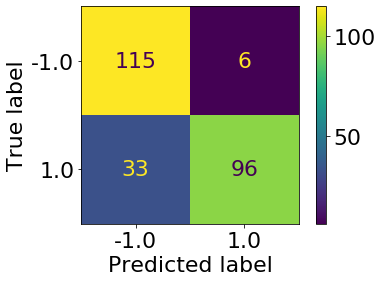

C:\Users\GeorgeE\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\GeorgeE\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\GeorgeE\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\

              precision    recall  f1-score   support

        -1.0       0.78      0.95      0.86       121
         0.0       0.00      0.00      0.00         0
         1.0       0.94      0.74      0.83       129

   micro avg       0.84      0.84      0.84       250
   macro avg       0.57      0.56      0.56       250
weighted avg       0.86      0.84      0.84       250

SVM
0.84


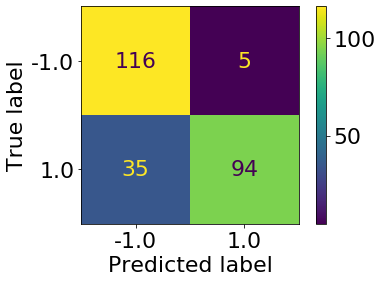

              precision    recall  f1-score   support

        -1.0       0.77      0.96      0.85       121
         0.0       0.00      0.00      0.00         0
         1.0       0.95      0.73      0.82       129

   micro avg       0.84      0.84      0.84       250
   macro avg       0.57      0.56      0.56       250
weighted avg       0.86      0.84      0.84       250

GNB
0.708


C:\Users\GeorgeE\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\GeorgeE\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\GeorgeE\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\

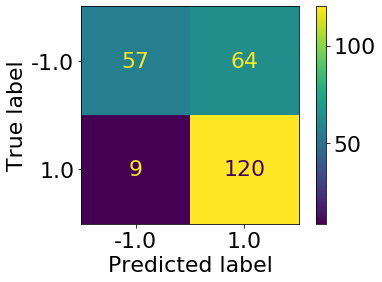

              precision    recall  f1-score   support

        -1.0       0.86      0.47      0.61       121
         0.0       0.00      0.00      0.00         0
         1.0       0.65      0.93      0.77       129

   micro avg       0.71      0.71      0.71       250
   macro avg       0.51      0.47      0.46       250
weighted avg       0.75      0.71      0.69       250



C:\Users\GeorgeE\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\GeorgeE\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\GeorgeE\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\

In [81]:
run_models(models, X_train_tf, X_test_tf, Y_train_tf, Y_test_tf, [-1.0, 0.0, 1.0])